<a href="https://colab.research.google.com/github/nitin-vig/ERAv4S7/blob/main/CIFAR10v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Improve Model Accuracy.

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

**Compute Mean and Standard Deviation for Normalization of data**. Commented as it is needed only once

In [ ]:
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader
# from tqdm import tqdm

# def get_mean_and_std(dataloader):
#     """
#     Calculate the mean and standard deviation of a dataset.

#     Args:
#         dataloader (DataLoader): The DataLoader for the dataset.

#     Returns:
#         tuple: The mean and standard deviation tensors for each channel.
#     """
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0
#     for data, _ in tqdm(dataloader, desc="Calculating mean and std"):
#         # Mean over batch, height, and width, but not over the channels
#         channels_sum += torch.mean(data, dim=[0, 2, 3])
#         channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
#         num_batches += 1

#     mean = channels_sum / num_batches
#     # Std = sqrt(E[X^2] - (E[X])^2)
#     std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
#     return mean, std

# # 1. Load the dataset without normalization (only convert to tensor)
# # This will automatically download the dataset if it's not present
# transform = transforms.Compose([transforms.ToTensor()])
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# # 2. Create a DataLoader
# train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

# # 3. Get the mean and standard deviation
# mean, std = get_mean_and_std(train_loader)

# print('Calculated Mean:', mean)
# print('Calculated Standard Deviation:', std)

# 100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]
# Calculating mean and std: 100%|██████████| 391/391 [00:06<00:00, 61.66it/s]
# Calculated Mean: tensor([0.4914, 0.4822, 0.4465])
# Calculated Standard Deviation: tensor([0.2470, 0.2435, 0.2616])

In [ ]:
# Train Phase transformations
# train_transforms = transforms.Compose([

#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616),), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
#                                        A.CoarseDropout(num_holes_range=(1,1),hole_height_range=(16,16),hole_width_range=(16,16),p=0.5),
#                                        A.HorizontalFlip(0.5),
#                                        A.ShiftScaleRotate(shift_limit=1,scale_limit=1,rotate_limit=1,p=0.5)
#                                        ])
# Define your Albumentations pipeline
albumentations_transforms = A.Compose([
    A.Normalize(
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2470, 0.2435, 0.2616),
    ),
    A.HorizontalFlip(0.5),
    A.ShiftScaleRotate(shift_limit=1,scale_limit=1,rotate_limit=1,p=0.5),
    A.CoarseDropout(
        num_holes=1,
        max_h_size=16,
        max_w_size=16,
        fill_value=0.4822,
        p=0.5
    ),
    ToTensorV2(),
])

# Use a lambda to wrap the Albumentations call
train_transforms = lambda img: albumentations_transforms(image=np.array(img))['image']


# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
                                       ])

/tmp/ipython-input-817236643.py:18: UserWarning: Argument(s) 'num_holes, max_h_size, max_w_size, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(


In [ ]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


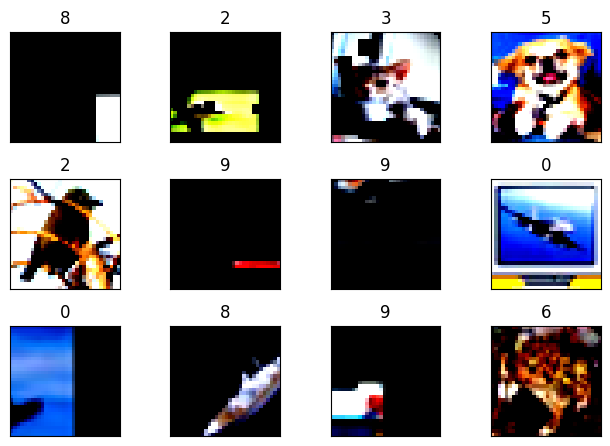

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  # plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.imshow(batch_data[i].permute(1,2,0))

  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Define the multiple-layer convolutional block
        self.conv_block1 = nn.Sequential(nn.Conv2d(3, 16, 3, padding=16), # input size=64 , RF = 3, outputsize=62, Jout =1,
                                    nn.ReLU(), nn.BatchNorm2d(16),

                                    nn.Conv2d(16, 16, 3, padding=0),      # input size=62 , RF = 5, outputsize=60, Jout =1
                                    nn.ReLU(),nn.BatchNorm2d(16),

                                    nn.Conv2d(16, 32, 3, padding=0),      # input size=60 , RF = 7, outputsize=58, Jout =1
                                    nn.ReLU(), nn.BatchNorm2d(32),

                                    nn.Conv2d(32, 64, 3, padding=0, stride=2),# input size=58 , RF = 9, outputsize=28, Jout=2
                                    nn.ReLU(),nn.BatchNorm2d(64),
                                  )


        self.conv_block2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
                                    nn.BatchNorm2d(16)) # input size=28 , RF = 9, outputsize=28, Jout=2

        self.conv_block3 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=0),# input size=28 , RF = 13, outputsize=26,Jout=2
                                    nn.ReLU(),nn.BatchNorm2d(32),

                                    nn.Conv2d(32, 64, 3, padding=0,dilation=2),# input size=26 , RF = 21, outputsize=22, Jout=2 # dilation of 2~ 5x5 kernel
                                    nn.ReLU(),nn.BatchNorm2d(64),

                                    nn.Conv2d(64, 64, 3, stride=2,padding=1),# input size=22 , RF = 25, outputsize=11, Jout=4
                                    nn.ReLU(),nn.BatchNorm2d(64),
                                    )

        self.conv_block4 = nn.Sequential(
                                    nn.Conv2d(64, 32, 3),# input size=11 , RF = 33, outputsize=9, Jout=4
                                    nn.ReLU(),nn.BatchNorm2d(32),

                                    nn.Conv2d(32, 32, 3),# input size=9 , RF = 41, outputsize=7, Jout=4
                                    nn.ReLU(),nn.BatchNorm2d(32),

                                    nn.Conv2d(32, 16, 3),# input size=7 , RF = 49, outputsize=5, Jout=4
                                    nn.ReLU(),nn.BatchNorm2d(16),

                                    nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
                                    nn.BatchNorm2d(10),
                                    nn.AvgPool2d(kernel_size=5)
                                    )

    def forward(self, x):
        # Block 1
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 62, 62]             448
              ReLU-2           [-1, 16, 62, 62]               0
       BatchNorm2d-3           [-1, 16, 62, 62]              32
            Conv2d-4           [-1, 16, 60, 60]           2,320
              ReLU-5           [-1, 16, 60, 60]               0
       BatchNorm2d-6           [-1, 16, 60, 60]              32
            Conv2d-7           [-1, 32, 58, 58]           4,640
              ReLU-8           [-1, 32, 58, 58]               0
       BatchNorm2d-9           [-1, 32, 58, 58]              64
           Conv2d-10           [-1, 64, 28, 28]          18,496
             ReLU-11           [-1, 64, 28, 28]               0
      BatchNorm2d-12           [-1, 64, 28, 28]             128
           Conv2d-13           [-1, 16, 28, 28]           1,024
      BatchNorm2d-14           [-1

In [ ]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1) ## Learning: adjust LR to a smaller value after every 5 epochs for fine tuning

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  # Update the learning rate
  scheduler.step()


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=1.9782387018203735 Batch_id=195 Accuracy=27.12: 100%|██████████| 196/196 [00:31<00:00,  6.31it/s]



Test set: Average loss: 1.5581, Accuracy: 4259/10000 (42.59%)

EPOCH: 2


Loss=1.6482250690460205 Batch_id=195 Accuracy=34.29: 100%|██████████| 196/196 [00:22<00:00,  8.63it/s]



Test set: Average loss: 1.3753, Accuracy: 5139/10000 (51.39%)

EPOCH: 3


Loss=1.6531331539154053 Batch_id=195 Accuracy=38.96: 100%|██████████| 196/196 [00:22<00:00,  8.88it/s]



Test set: Average loss: 1.4456, Accuracy: 4684/10000 (46.84%)

EPOCH: 4


Loss=1.456578254699707 Batch_id=195 Accuracy=42.13: 100%|██████████| 196/196 [00:22<00:00,  8.68it/s]



Test set: Average loss: 1.1587, Accuracy: 5862/10000 (58.62%)

EPOCH: 5


Loss=1.525917410850525 Batch_id=195 Accuracy=43.56: 100%|██████████| 196/196 [00:23<00:00,  8.22it/s]



Test set: Average loss: 0.9964, Accuracy: 6507/10000 (65.07%)

EPOCH: 6


Loss=1.3139216899871826 Batch_id=195 Accuracy=45.32: 100%|██████████| 196/196 [00:23<00:00,  8.20it/s]



Test set: Average loss: 0.9472, Accuracy: 6655/10000 (66.55%)

EPOCH: 7


Loss=1.5311640501022339 Batch_id=195 Accuracy=47.08: 100%|██████████| 196/196 [00:22<00:00,  8.80it/s]



Test set: Average loss: 0.8880, Accuracy: 6921/10000 (69.21%)

EPOCH: 8


Loss=1.3082348108291626 Batch_id=195 Accuracy=48.53: 100%|██████████| 196/196 [00:22<00:00,  8.83it/s]



Test set: Average loss: 0.8256, Accuracy: 7110/10000 (71.10%)

EPOCH: 9


Loss=1.2709459066390991 Batch_id=195 Accuracy=49.30: 100%|██████████| 196/196 [00:22<00:00,  8.71it/s]



Test set: Average loss: 0.8077, Accuracy: 7217/10000 (72.17%)

EPOCH: 10


Loss=1.3911457061767578 Batch_id=195 Accuracy=50.64: 100%|██████████| 196/196 [00:21<00:00,  9.07it/s]



Test set: Average loss: 0.7906, Accuracy: 7266/10000 (72.66%)

EPOCH: 11


Loss=1.4544823169708252 Batch_id=195 Accuracy=51.39: 100%|██████████| 196/196 [00:21<00:00,  8.97it/s]



Test set: Average loss: 0.7423, Accuracy: 7438/10000 (74.38%)

EPOCH: 12


Loss=1.2816100120544434 Batch_id=195 Accuracy=51.78: 100%|██████████| 196/196 [00:22<00:00,  8.85it/s]



Test set: Average loss: 0.7168, Accuracy: 7588/10000 (75.88%)

EPOCH: 13


Loss=1.4327789545059204 Batch_id=195 Accuracy=52.60: 100%|██████████| 196/196 [00:23<00:00,  8.23it/s]



Test set: Average loss: 0.8310, Accuracy: 7161/10000 (71.61%)

EPOCH: 14


Loss=1.3653085231781006 Batch_id=195 Accuracy=52.80: 100%|██████████| 196/196 [00:23<00:00,  8.41it/s]



Test set: Average loss: 0.6781, Accuracy: 7701/10000 (77.01%)

EPOCH: 15


Loss=1.3439165353775024 Batch_id=195 Accuracy=53.48: 100%|██████████| 196/196 [00:23<00:00,  8.35it/s]



Test set: Average loss: 0.6863, Accuracy: 7658/10000 (76.58%)

EPOCH: 16


Loss=1.5400571823120117 Batch_id=195 Accuracy=54.13: 100%|██████████| 196/196 [00:23<00:00,  8.28it/s]



Test set: Average loss: 0.6755, Accuracy: 7698/10000 (76.98%)

EPOCH: 17


Loss=1.1959617137908936 Batch_id=195 Accuracy=54.37: 100%|██████████| 196/196 [00:23<00:00,  8.25it/s]



Test set: Average loss: 0.6909, Accuracy: 7606/10000 (76.06%)

EPOCH: 18


Loss=1.2771915197372437 Batch_id=195 Accuracy=55.08: 100%|██████████| 196/196 [00:23<00:00,  8.26it/s]



Test set: Average loss: 0.6113, Accuracy: 7921/10000 (79.21%)

EPOCH: 19


Loss=1.2684285640716553 Batch_id=195 Accuracy=55.20: 100%|██████████| 196/196 [00:25<00:00,  7.80it/s]



Test set: Average loss: 0.6386, Accuracy: 7870/10000 (78.70%)

EPOCH: 20


Loss=1.2846968173980713 Batch_id=195 Accuracy=55.57: 100%|██████████| 196/196 [00:23<00:00,  8.25it/s]



Test set: Average loss: 0.6657, Accuracy: 7753/10000 (77.53%)

EPOCH: 21


Loss=1.3371349573135376 Batch_id=195 Accuracy=55.78: 100%|██████████| 196/196 [00:23<00:00,  8.33it/s]



Test set: Average loss: 0.6155, Accuracy: 7836/10000 (78.36%)

EPOCH: 22


Loss=1.2478346824645996 Batch_id=195 Accuracy=55.95: 100%|██████████| 196/196 [00:23<00:00,  8.27it/s]



Test set: Average loss: 0.6044, Accuracy: 7944/10000 (79.44%)

EPOCH: 23


Loss=1.349287986755371 Batch_id=195 Accuracy=56.32: 100%|██████████| 196/196 [00:23<00:00,  8.24it/s]



Test set: Average loss: 0.5769, Accuracy: 8003/10000 (80.03%)

EPOCH: 24


Loss=1.213793158531189 Batch_id=195 Accuracy=56.78: 100%|██████████| 196/196 [00:23<00:00,  8.22it/s]



Test set: Average loss: 0.5646, Accuracy: 8094/10000 (80.94%)

EPOCH: 25


Loss=1.2552063465118408 Batch_id=195 Accuracy=56.92: 100%|██████████| 196/196 [00:24<00:00,  8.09it/s]



Test set: Average loss: 0.5662, Accuracy: 8116/10000 (81.16%)

EPOCH: 26


Loss=1.0780704021453857 Batch_id=195 Accuracy=57.16: 100%|██████████| 196/196 [00:25<00:00,  7.72it/s]



Test set: Average loss: 0.5724, Accuracy: 8084/10000 (80.84%)

EPOCH: 27


Loss=1.334280252456665 Batch_id=195 Accuracy=57.25: 100%|██████████| 196/196 [00:24<00:00,  8.06it/s]



Test set: Average loss: 0.5571, Accuracy: 8095/10000 (80.95%)

EPOCH: 28


Loss=1.1160812377929688 Batch_id=195 Accuracy=57.42: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]



Test set: Average loss: 0.5503, Accuracy: 8174/10000 (81.74%)

EPOCH: 29


Loss=1.1125147342681885 Batch_id=195 Accuracy=58.05: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]



Test set: Average loss: 0.5747, Accuracy: 8028/10000 (80.28%)

EPOCH: 30


Loss=1.2626659870147705 Batch_id=195 Accuracy=57.83: 100%|██████████| 196/196 [00:24<00:00,  8.10it/s]



Test set: Average loss: 0.5934, Accuracy: 8039/10000 (80.39%)

EPOCH: 31


Loss=1.1574666500091553 Batch_id=195 Accuracy=58.12: 100%|██████████| 196/196 [00:24<00:00,  8.04it/s]



Test set: Average loss: 0.5623, Accuracy: 8101/10000 (81.01%)

EPOCH: 32


Loss=1.2321161031723022 Batch_id=195 Accuracy=58.30: 100%|██████████| 196/196 [00:24<00:00,  8.06it/s]



Test set: Average loss: 0.5477, Accuracy: 8143/10000 (81.43%)

EPOCH: 33


Loss=1.1502541303634644 Batch_id=195 Accuracy=58.01: 100%|██████████| 196/196 [00:24<00:00,  7.87it/s]



Test set: Average loss: 0.5328, Accuracy: 8224/10000 (82.24%)

EPOCH: 34


Loss=1.1515882015228271 Batch_id=195 Accuracy=58.33: 100%|██████████| 196/196 [00:24<00:00,  7.92it/s]



Test set: Average loss: 0.5631, Accuracy: 8125/10000 (81.25%)

EPOCH: 35


Loss=1.0823171138763428 Batch_id=195 Accuracy=58.42: 100%|██████████| 196/196 [00:25<00:00,  7.68it/s]



Test set: Average loss: 0.5445, Accuracy: 8129/10000 (81.29%)

EPOCH: 36


Loss=1.0831377506256104 Batch_id=195 Accuracy=58.67: 100%|██████████| 196/196 [00:25<00:00,  7.72it/s]



Test set: Average loss: 0.5402, Accuracy: 8159/10000 (81.59%)

EPOCH: 37


Loss=1.06024968624115 Batch_id=195 Accuracy=58.88: 100%|██████████| 196/196 [00:24<00:00,  8.01it/s]



Test set: Average loss: 0.5658, Accuracy: 8077/10000 (80.77%)

EPOCH: 38


Loss=1.0905617475509644 Batch_id=195 Accuracy=59.05: 100%|██████████| 196/196 [00:23<00:00,  8.19it/s]



Test set: Average loss: 0.5078, Accuracy: 8301/10000 (83.01%)

EPOCH: 39


Loss=1.1599801778793335 Batch_id=195 Accuracy=59.18: 100%|██████████| 196/196 [00:25<00:00,  7.83it/s]



Test set: Average loss: 0.5649, Accuracy: 8108/10000 (81.08%)

EPOCH: 40


Loss=1.1518570184707642 Batch_id=195 Accuracy=59.11: 100%|██████████| 196/196 [00:23<00:00,  8.18it/s]



Test set: Average loss: 0.5081, Accuracy: 8277/10000 (82.77%)

EPOCH: 41


Loss=1.173154354095459 Batch_id=195 Accuracy=60.70: 100%|██████████| 196/196 [00:24<00:00,  8.01it/s]



Test set: Average loss: 0.4545, Accuracy: 8454/10000 (84.54%)

EPOCH: 42


Loss=1.0146722793579102 Batch_id=195 Accuracy=61.58: 100%|██████████| 196/196 [00:24<00:00,  7.99it/s]



Test set: Average loss: 0.4479, Accuracy: 8474/10000 (84.74%)

EPOCH: 43


Loss=1.06778085231781 Batch_id=195 Accuracy=61.62: 100%|██████████| 196/196 [00:24<00:00,  8.02it/s]



Test set: Average loss: 0.4467, Accuracy: 8504/10000 (85.04%)

EPOCH: 44


Loss=1.0300902128219604 Batch_id=195 Accuracy=61.24: 100%|██████████| 196/196 [00:24<00:00,  7.93it/s]



Test set: Average loss: 0.4455, Accuracy: 8512/10000 (85.12%)

EPOCH: 45


Loss=1.2781670093536377 Batch_id=195 Accuracy=61.69: 100%|██████████| 196/196 [00:24<00:00,  7.84it/s]



Test set: Average loss: 0.4490, Accuracy: 8494/10000 (84.94%)

EPOCH: 46


Loss=0.9405881762504578 Batch_id=195 Accuracy=61.81: 100%|██████████| 196/196 [00:25<00:00,  7.80it/s]



Test set: Average loss: 0.4427, Accuracy: 8509/10000 (85.09%)

EPOCH: 47


Loss=1.0534511804580688 Batch_id=195 Accuracy=62.11: 100%|██████████| 196/196 [00:24<00:00,  7.92it/s]



Test set: Average loss: 0.4451, Accuracy: 8495/10000 (84.95%)

EPOCH: 48


Loss=1.1134363412857056 Batch_id=195 Accuracy=62.08: 100%|██████████| 196/196 [00:24<00:00,  7.94it/s]



Test set: Average loss: 0.4471, Accuracy: 8483/10000 (84.83%)

EPOCH: 49


Loss=1.0684049129486084 Batch_id=195 Accuracy=62.09: 100%|██████████| 196/196 [00:24<00:00,  8.07it/s]



Test set: Average loss: 0.4448, Accuracy: 8497/10000 (84.97%)

EPOCH: 50


Loss=1.1465415954589844 Batch_id=195 Accuracy=61.96: 100%|██████████| 196/196 [00:23<00:00,  8.23it/s]



Test set: Average loss: 0.4441, Accuracy: 8515/10000 (85.15%)



Text(0.5, 1.0, 'Test Accuracy')

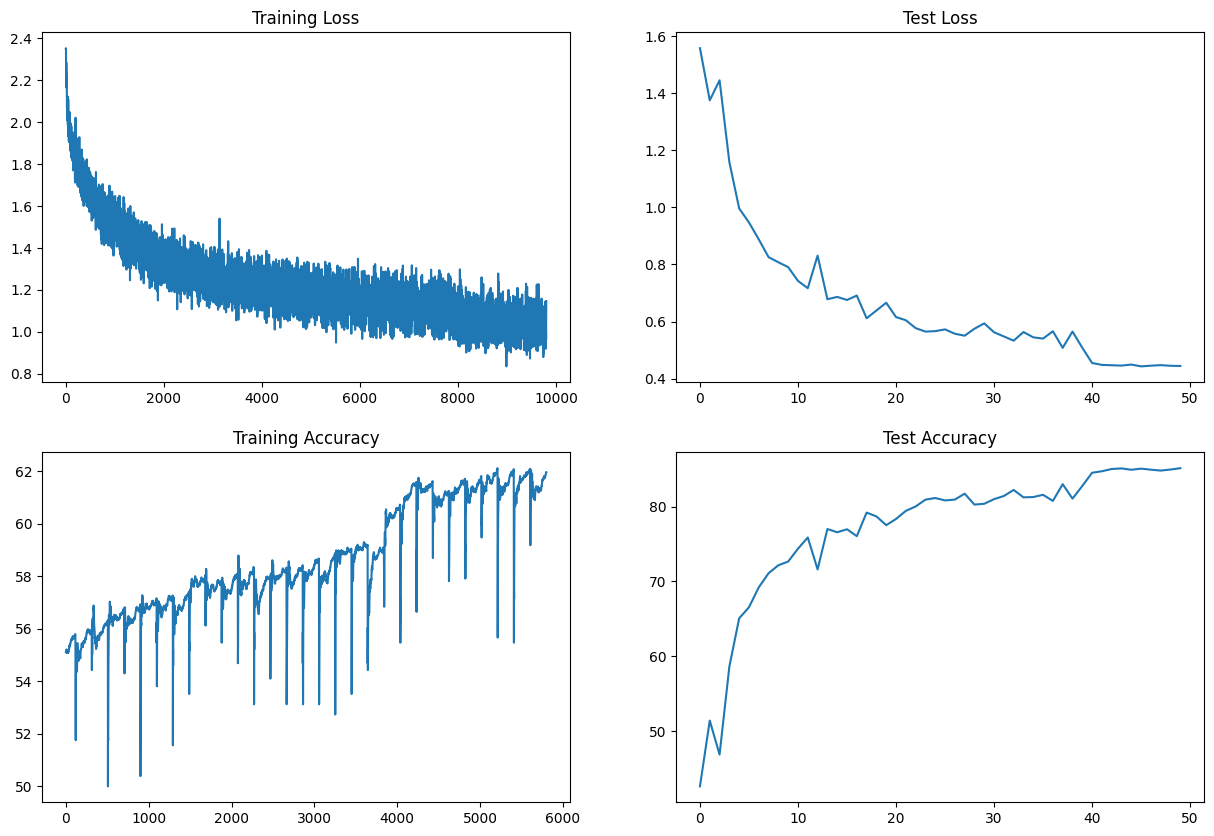

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")